# Momo's Campaign Insight Finding


# INTRODUCTION
The aim of the campaign is to accquire and retain users, convert them into frequent users of Momo. Could you evaluate the performance of the campaign? Is there any interesting pattern in the data? And finally can we do anything about the secret you just found? 

## Data Description
- TRAN_ID:	The identity of  the transaction
- USER_ID:	The identity of  the user
- CITY:	The city where the transaction took place, 'Others' is include all the provinces/city other than HCM and Hanoi
- AGENT:	Store category of the transaction
- STATUS:	The retaining status of the user. If the user continue to user Momo in the week after, then the user is labeled as retain, else churn
- SHOP_ID:	Identity of the shop in which the transaction took place
- TIME_TO_CONVERT:	Measure in day. How long it's been since the first payment made by user to the day that the user made the first offline payment

## Results from the study
- There are 78.92% of churn customers, 21.08% of retain customers.
- Shop_id 1 and 2 drive most customers at 33.68% and 37.71% of total.
- HCM Customers are more likely to retain, compared to those from Ha Noi and Others
- Shop_id 3 and 5 achieve the highest retention rate of 0.45 and 0.4, however they just account for 5.96% and 6.8 % of customers.
- Shop_id 6 is the only one to inherite both characteristics from Super Market and Convience Store.
- We may use the combination of TIME_TO_CONVERT and CITY to derive the insight from customers' STATUS.
- Clean valueS in CITY, TIME_TO_CONVERT. Remove unnecessary columns like TRAIN_ID, USER_ID
- The important features for prediction capability are CITY, SHIP_ID, AGENT, TIME_TO_CONVERT
- The Partial Dependence Plots shows the longer people make their first offline payment, the less likely are they truely become our customers.
- Use SHAP helps us realize how variables impact on customer STATUS.

# LIBRARY

In [1]:
# Data Processing
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler

# Data Visualizing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from IPython.display import display, HTML

# Data Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC, NuSVC

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Data Validation
from sklearn import metrics

# Math
from scipy import stats  # Computing the t and p values using scipy 
from statsmodels.stats import weightstats 
import math
from scipy.stats import norm

# Warning Removal
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

# DATA EXPLORATION

In [2]:
df = pd.read_csv('../input/Momo_Secret_Finding.csv')


In [3]:
df.head()

,TRAN_ID,USER_ID,CITY,AGENT,STATUS,SHOP_ID,TIME_TO_CONVERT
0,9508197865,617382002,Ha Noi,SUPER_MARKET,churn,2,25.0
1,9534879723,446358434,HCM,CONVINIENCE_STORE,churn,1,371.0
2,9502868333,336774823,HCM,CONVINIENCE_STORE,churn,3,NaN
3,9519944030,610624716,Ha Noi,SUPER_MARKET,churn,2,15.0
4,9521883750,342036649,Others,SUPER_MARKET,churn,2,49.0


#### Observation
- City and Time_To_Convert have missing values

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

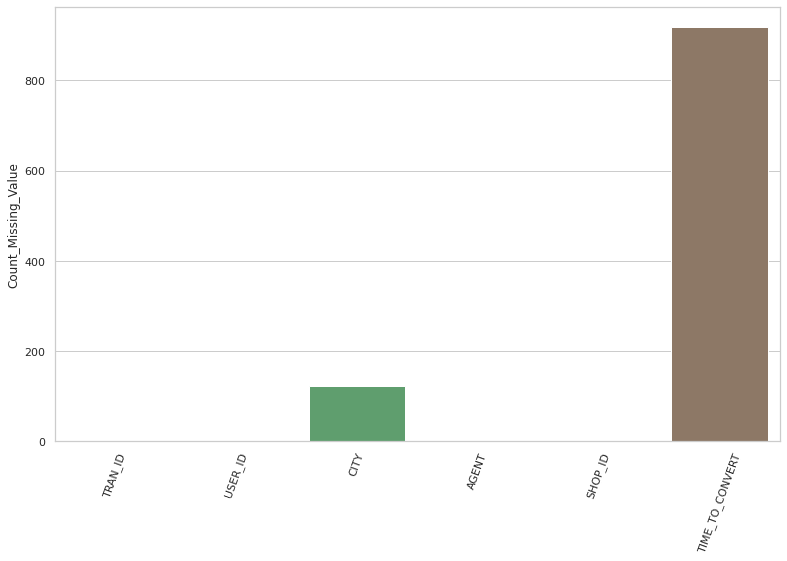

In [4]:
zero_count = (df.isnull()).sum() # (df1 == 0).sum()
zero_count_df = pd.DataFrame(zero_count)
zero_count_df.drop('STATUS', axis=0, inplace=True)
zero_count_df.columns = ['Count_Missing_Value']

# https://stackoverflow.com/questions/31859285/rotate-tick-labels-for-seaborn-barplot/60530167#60530167
sns.set(style='whitegrid')
plt.figure(figsize=(13,8))
sns.barplot(x=zero_count_df.index, y=zero_count_df['Count_Missing_Value'])
plt.xticks(rotation=70)

In [5]:
cats = ['CITY', 'AGENT', 'STATUS', 'SHOP_ID']

def plotFrequency(cats):
    #"A plot for visualize categorical data, showing both absolute and relative frequencies"
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.flatten()

    for ax, cat in zip(axes, cats):
        total = float(len(df[cat]))
        sns.countplot(df[cat], palette='plasma', ax=ax)

        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha="center")

        plt.ylabel('Count', fontsize=15, weight='bold')

#### Observation
- In City feature: Most customers come from HCM, while customers from Ha Noi and Other are equal at lower level.
- In Agent feature: the channels through Super Market and Convience Store are almost similar.
- In Status feature: 78.92% of churn customers, while only 21.08% of retain customers.
- In Shop_id: 2 most popular shop are Shop_id 1 and 2 accounting for 33.68% and 37.71% respectively. While Shop_Id 3, 4, 5, 6 share the same market portion around 6%.

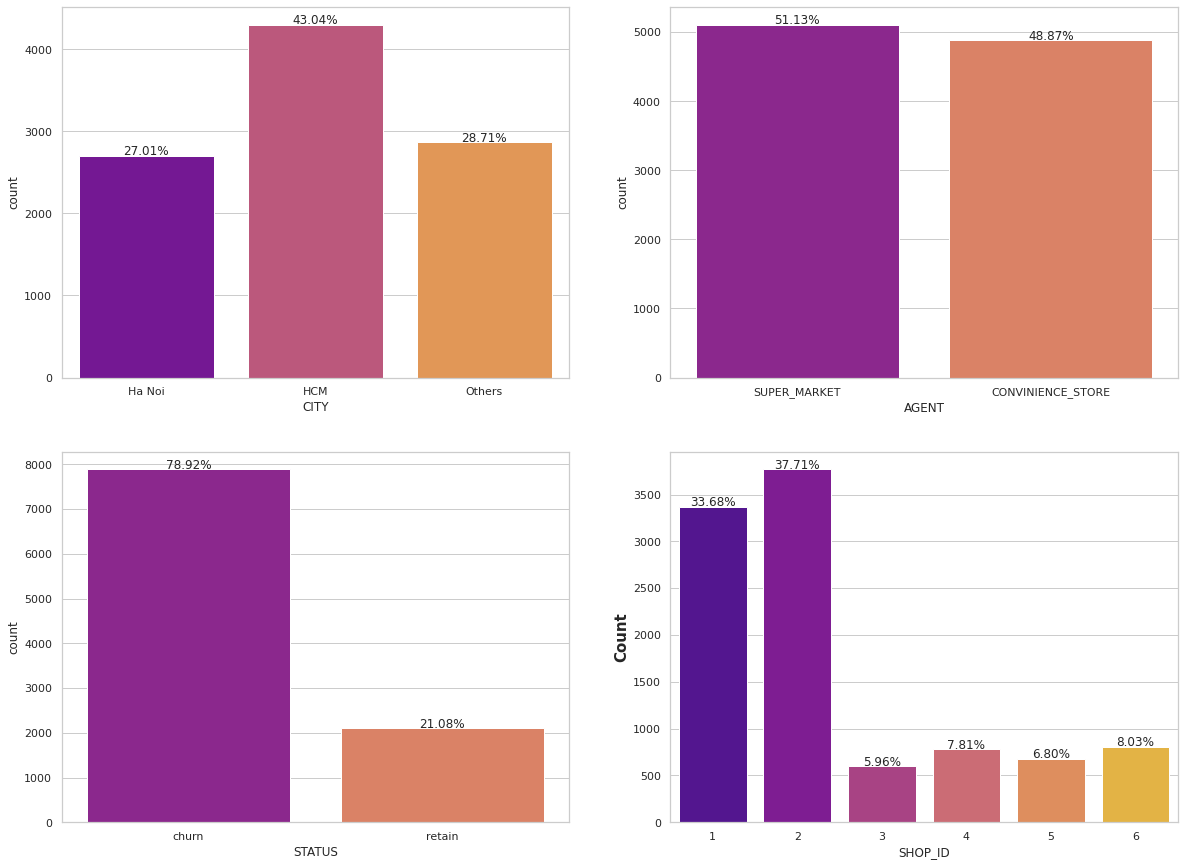

In [6]:
plotFrequency(cats)

In [7]:
def plotStatus(cats):
    #"A plot for visualize categorical data, showing both absolute and relative frequencies"
    fig, axes = plt.subplots(2, 2, figsize=(25, 20))
    axes = axes.flatten()

    for ax, cat in zip(axes, cats):
        total = float(len(df[cat]))
        sns.countplot(df[cat], palette='plasma',hue=df['STATUS'], ax=ax)
        
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha="center")
        
        
        ax.legend(title='STATUS?',loc='upper right',labels=['Churn', 'Retain'])
        
        plt.ylabel('Count', fontsize=15, weight='bold')
        display

#### Observation
- The City graph shows customers come from HCM are more likely to retain, following those from Others, and those from Ha Noi least retaining.
- The Agent graph indicates Convenience Store tend to attract and keep customers with us more than Super Market channel.
- The Shop_ID gives an interesting information. Shop_id 1 and 2 attract most consumers but with least retention rate. Shop_id 3 comes from City of Others and Agent of Convience Store only outperform other shop_id, at 0.45 (1.85/4.11), following by Shop_id 5 with retention rate of 0.4 (1.96/4.84)

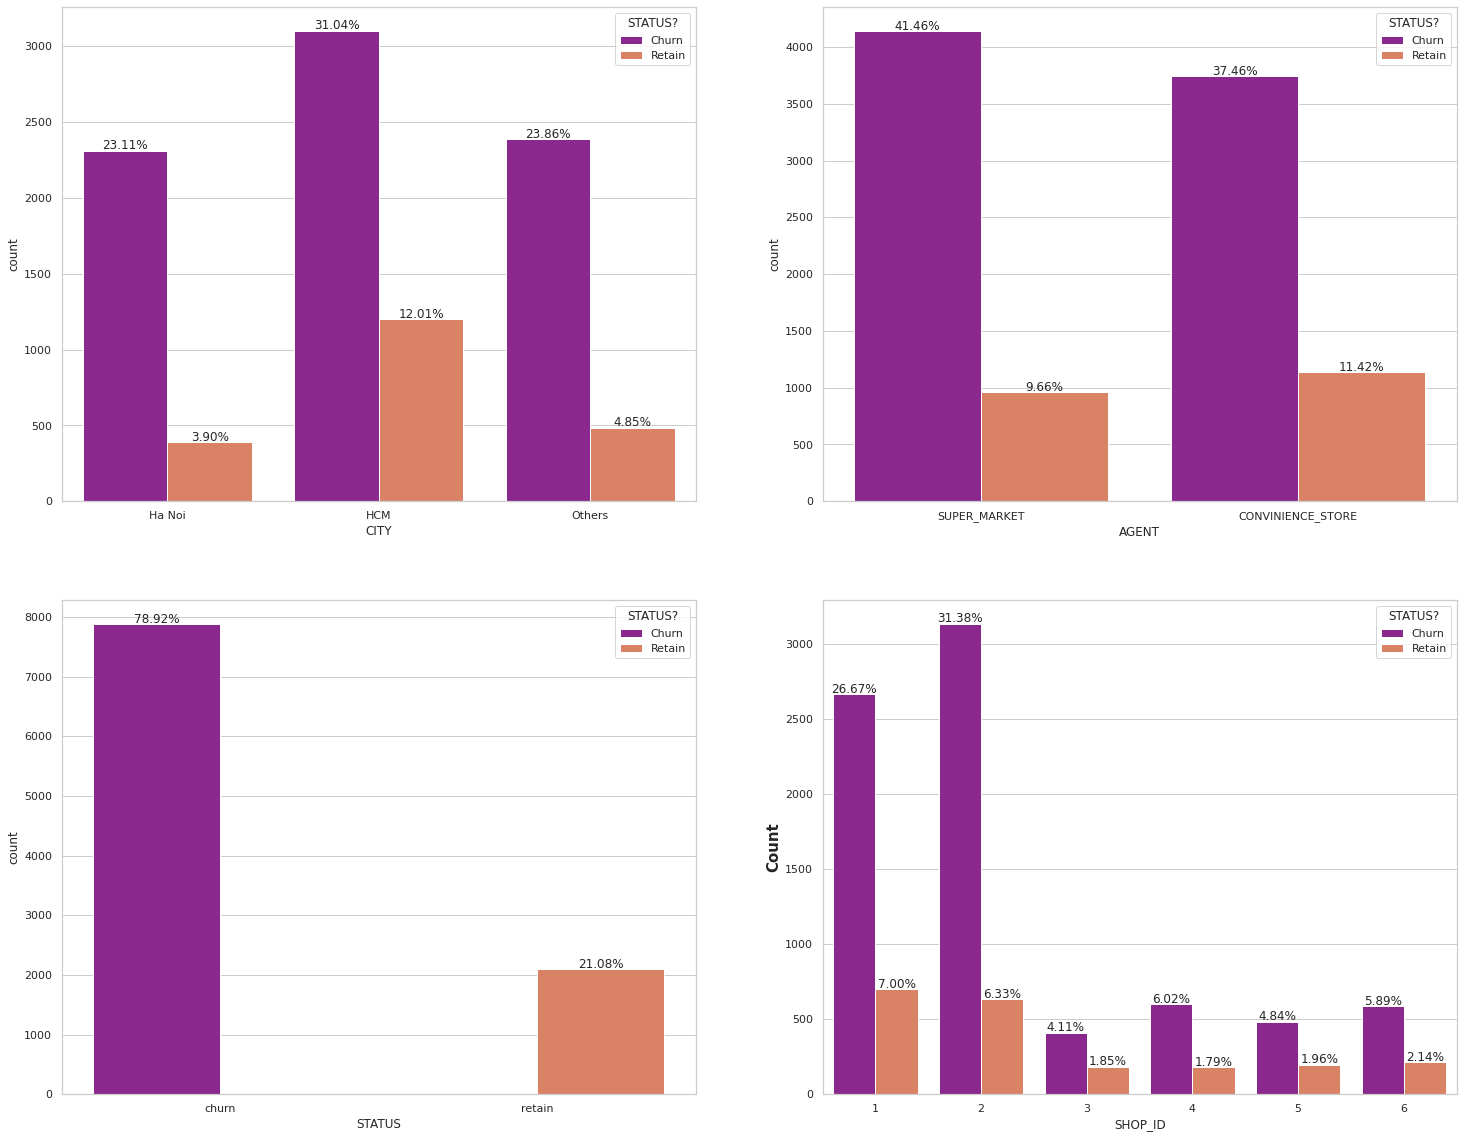

In [8]:
plotStatus(cats)

#### Observation
- We can't really predict a customer churn or retain our service based on TIME_TO_CONVERT against Status, as we can see the data point overlap.

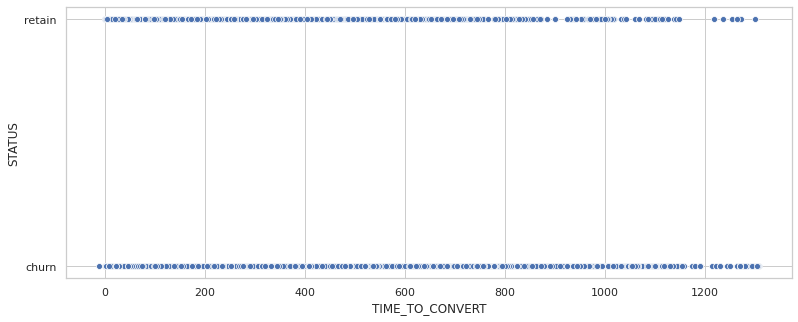

In [9]:
plt.figure(figsize=(13,5))
sns.scatterplot(x=df['TIME_TO_CONVERT'], y=df['STATUS'])

#### Observation
- Ploting a graph among 3 variable yeild better outcome. 
- People from Other City tend to retain at the second half of TIME_TO_CONVERT.
- People from HCM City tend to retain at the first quarter and the second half of TIME_TO_CONVERT.
- People from Ha Noi are unpredictable.

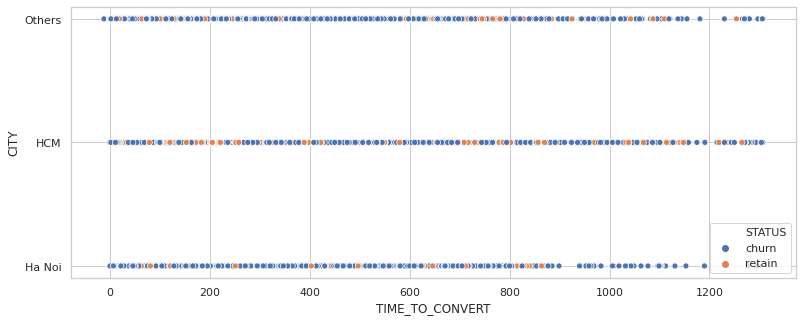

In [10]:
plt.figure(figsize=(13,5))
sns.scatterplot(x=df['TIME_TO_CONVERT'], y=df['CITY'], hue=df['STATUS'])

# DATA MANIPULATION
- Check duplicated values in TRAIN_ID, USER_ID
- Clean CITY feature
- Clean TIME_TO_CONVERT feature

### Check duplicated TRAIN_ID and USER_ID
- If Yes, remove those rows

In [11]:
print(df['TRAN_ID'].duplicated().sum())
print(df['USER_ID'].duplicated().sum())

0
0


### Remove missing values in CITY

In [12]:
df = df[df['CITY'].notnull()]

### Remove outliers in TIME_TO_CONVERT

In [13]:
# Time_to_convert can't be negative value as following the data description, 
# it is a period that the first payment made by user to the day that the user made the first offline payment
df = df[df['TIME_TO_CONVERT']>0]

### Replace missing values in TIME_TO_CONVERT

#### Observation
- Convert-time for categories of Churn and Retain shares the same pattern with the long right tail, called right-skwed distribution.
- Thus, we impute missing values with median according to their types

Text(0.5, 1.0, 'Retain_Convert_Time')

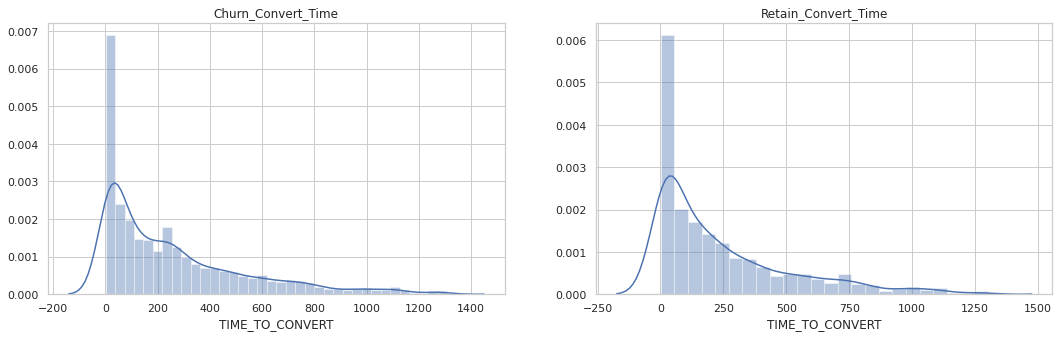

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

Churn_Convert_Time = df[df['STATUS']=='churn']['TIME_TO_CONVERT']
sns.distplot(Churn_Convert_Time, ax=axes[0]).set_title("Churn_Convert_Time")

Retain_Convert_Time = df[df['STATUS']=='retain']['TIME_TO_CONVERT']
sns.distplot(Retain_Convert_Time, ax=axes[1]).set_title("Retain_Convert_Time")

In [15]:
# Median value of TIME_TO_CONVERT for churn customers
print(df[df['STATUS']=='churn']['TIME_TO_CONVERT'].median())

# Median value of TIME_TO_CONVERT for retain customers
print(df[df['STATUS']=='retain']['TIME_TO_CONVERT'].median())

168.5
144.5


In [16]:
# Filling the missing values
df.loc[(df['STATUS'] == 'churn' ) & (df['TIME_TO_CONVERT'].isnull()), 'TIME_TO_CONVERT'] = 168
df.loc[(df['STATUS'] == 'retain' ) & (df['TIME_TO_CONVERT'].isnull()), 'TIME_TO_CONVERT'] = 144.5

#### Observation
- The variable is right-skwed. As (linear) models love normal distributed date, we need to transform this variable and make it more normally distributed.
- Applying log1p on the TIME_TO_CONVERT to center the data. As the result, the curve blue line seems to align with the red line.

In [17]:
def plot_3chart(feature):
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    # creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df[feature], hist=True, kde=True, fit=norm, color='#e74c3c', ax=ax1)
    ax1.legend(labels=['Normal', 'Actual'])
    
    # customizing the QQ_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Probability Plot')
    # Plotting the QQ_Plot.
    stats.probplot(df[feature].fillna(np.median(df.loc[:, feature])), plot=ax2)
    #ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)
    
     # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(df[feature], orient='v', color='#e74c3c', ax=ax3)
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.suptitle(f'{feature}', fontsize=24)

#### Observation
- The variable is right-skwed. As (linear) models love normal distributed date, we need to transform this variable and make it more normally distributed.
- Applying log1p on the TIME_TO_CONVERT to center the data. As the result, the curve blue line seems to align with the red line.

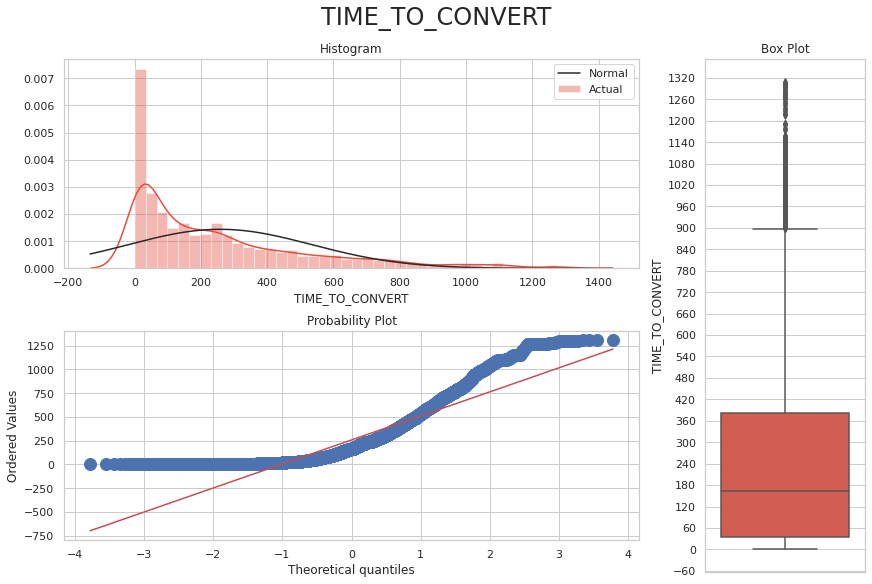

In [18]:
plot_3chart('TIME_TO_CONVERT')

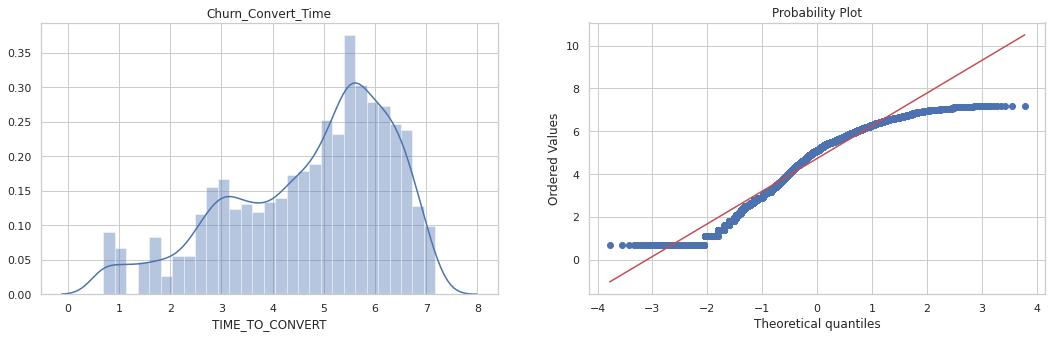

In [19]:
df['TIME_TO_CONVERT'] = np.log1p(df['TIME_TO_CONVERT'])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

sns.distplot(df['TIME_TO_CONVERT'], ax=axes[0]).set_title("Churn_Convert_Time")

#Get also the QQ-plot
res = stats.probplot(df['TIME_TO_CONVERT'], plot=axes[1])
plt.show()

### Remove unnecessary columns

In [20]:
df.drop(['TRAN_ID', 'USER_ID'], axis=1, inplace=True)

### Transform datatype

In [21]:
df['SHOP_ID'] = df['SHOP_ID'].astype('str')

### Apply one-hot-encoding on data prior to ML models

In [22]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,TIME_TO_CONVERT,CITY_Ha Noi,CITY_Others,AGENT_SUPER_MARKET,STATUS_retain,SHOP_ID_2,SHOP_ID_3,SHOP_ID_4,SHOP_ID_5,SHOP_ID_6
0,3.258097,1,0,1,0,1,0,0,0,0
1,5.918894,0,0,0,0,0,0,0,0,0
3,2.772589,1,0,1,0,1,0,0,0,0
4,3.912023,0,1,1,0,1,0,0,0,0
5,5.780744,0,0,1,0,1,0,0,0,0


### Split Independent and Dependent Variables

In [23]:
x = df.drop('STATUS_retain', axis=1)
y = df['STATUS_retain']

# Usually we need to bring all features to the same scale using StandardScaler or Normalizer or Boxcox. 
# But in this case, it won't yield better result
# x = StandardScaler().fit_transform(df.drop('STATUS_retain', axis=1))
# y = df['STATUS_retain']

# MODELING
- The purpose of model is to predict if a user churns or retains

### Define a cross validation function

In [24]:
cv = StratifiedKFold(10, shuffle=True, random_state=0)

def model_check(X, y, estimators, cv):
    model_table = pd.DataFrame()
    
    row_index = 0
    for est in estimators:

        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name
        #    model_table.loc[row_index, 'MLA Parameters'] = str(est.get_params())

        cv_results = cross_validate(est,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='accuracy',
                                    return_train_score=True,
                                   )

        model_table.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
        model_table.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

        model_table.sort_values(by=['Test Accuracy Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

### Models

In [25]:
logreg = LogisticRegression(n_jobs=-1, solver='newton-cg')

knn = KNeighborsClassifier(n_neighbors=13)

gnb = GaussianNB()

linearSVC = LinearSVC()

RbfSVC = SVC()

dt = DecisionTreeClassifier(max_depth=10)

rf = RandomForestClassifier(random_state=0,n_jobs=-1,verbose=0)

adab = AdaBoostClassifier(random_state=0)

gb = GradientBoostingClassifier(random_state=0)

xgb = XGBClassifier(random_state=0)

lgbm = LGBMClassifier(random_state=0)

votingC = VotingClassifier(estimators=[("XGB", xgb), ("GB", gb), ("DecisionTree", dt),('LightGBM', lgbm)], 
                           voting='soft', n_jobs=4)

In [26]:
estimators = [logreg,knn,gnb,linearSVC,RbfSVC,dt,rf,gb,xgb,lgbm,votingC]

### Models Evaluation
- It seems like the models do not really perform better than the baseline model (79% churn, 21% retain)

In [27]:
raw_models = model_check(x, y, estimators, cv)
display(raw_models.style.background_gradient(cmap='summer_r'))

,Model Name,Train Accuracy Mean,Test Accuracy Mean,Test Std,Time
0,LogisticRegression,0.802990,0.803154,0.000482,0.284759
3,LinearSVC,0.803041,0.803041,0.000490,0.500502
4,SVC,0.803041,0.803041,0.000490,1.276937
7,GradientBoostingClassifier,0.804453,0.801679,0.000948,0.505369
9,LGBMClassifier,0.806949,0.799183,0.003612,0.106382
10,VotingClassifier,0.812205,0.796913,0.004086,1.145704
1,KNeighborsClassifier,0.806091,0.796688,0.004178,0.018445
8,XGBClassifier,0.820399,0.791808,0.004316,0.295463
5,DecisionTreeClassifier,0.819504,0.785454,0.004361,0.015678
2,GaussianNB,0.736127,0.735082,0.015170,0.007150


### Explore 3 most Important Features in each models
- In XGBoost: City, Shop_id, Agent
- In Gradient Decent: Time_to_convert, City, Shop_id
- In Decision Tree: Time_to_convert, Shop_id, City,
- In Random Forest: Time_to_convert

In [28]:
xgb = XGBClassifier(random_state=0).fit(x, y)
gb = GradientBoostingClassifier(random_state=0).fit(x, y)
dt = DecisionTreeClassifier(max_depth=10).fit(x, y)
rf = RandomForestClassifier(random_state=0,n_jobs=-1,verbose=0).fit(x, y)

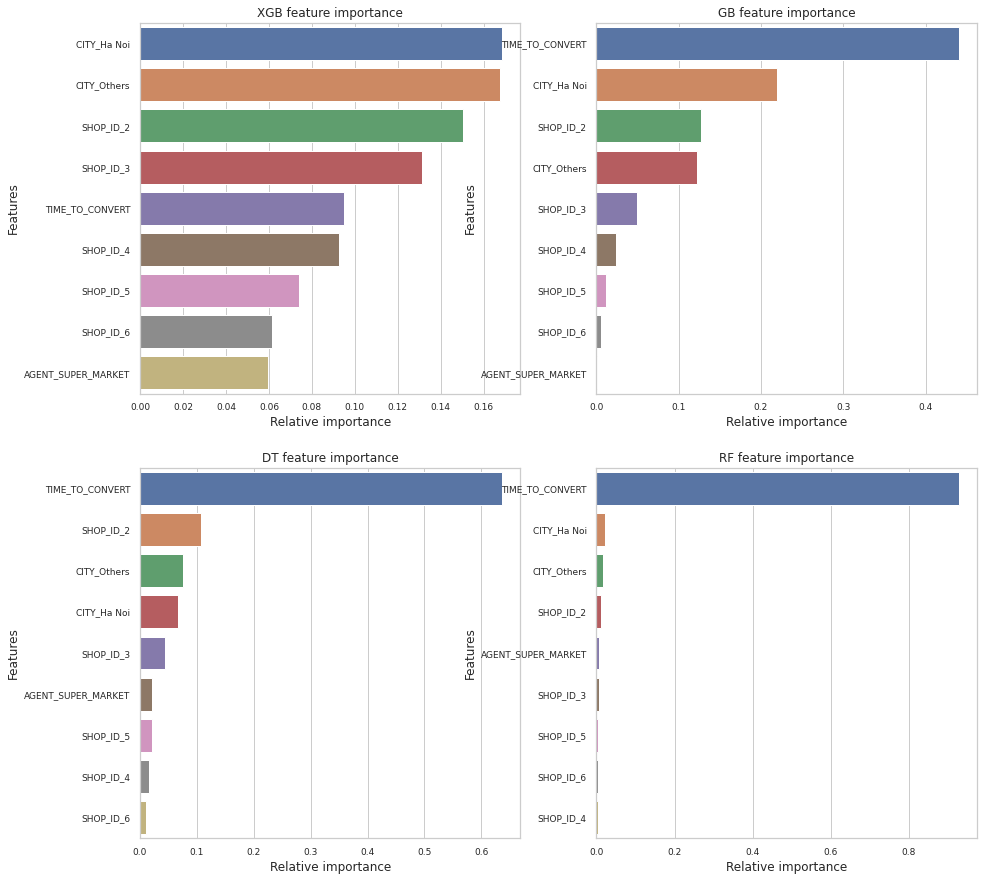

In [29]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15,15))

names_classifiers = [("XGB", xgb), ("GB", gb), ('DT', dt), ('RF', rf)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=x.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

### Partial Dependence Plots
- The Y-axis represents the change in prediction from what it would be predicted at the baseline or leftmost value.
- Blue area denotes the confidence interval
- For the ‘TIME_TO_CONVERT’ graph, we observe that probability of a person having churn steeply decreases as the data passed level grows.

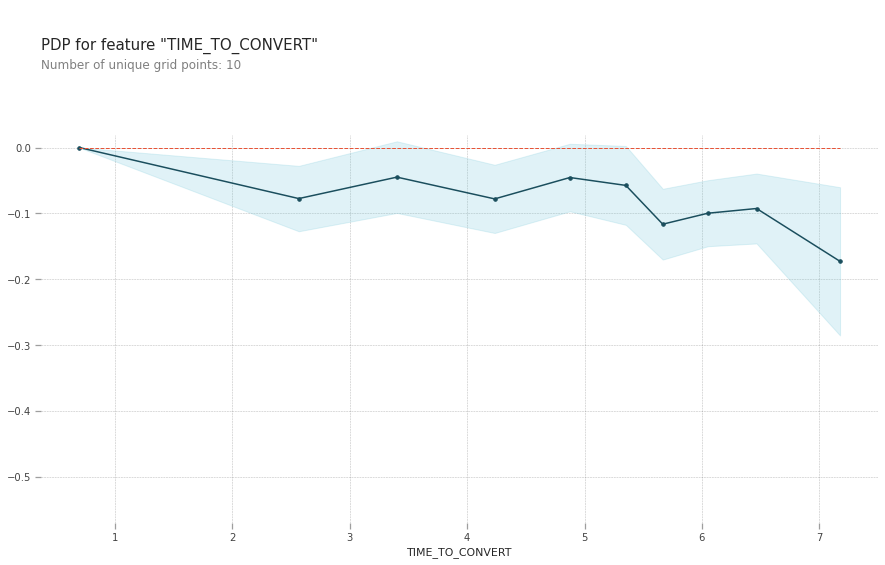

In [30]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=gb, dataset=x, model_features=x.columns, feature='TIME_TO_CONVERT')

# plot it
pdp.pdp_plot(pdp_goals, 'TIME_TO_CONVERT')
plt.show()

### SHAP Values
- Helps to break down a prediction to show the impact of each feature.
- Let's pick a random patient, here is 1, from our dataset to see how our model predict based on individual feature
- TIME_TO_CONVERT has the biggest impact on prediction of being churn
- CITY has the biggest impact on prediction of being retain

In [31]:
row_to_show = 1
data_for_prediction = x.iloc[row_to_show]

import shap
# Create object that can calculate shap values
explainer = shap.TreeExplainer(dt)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)